In [1]:
import numpy as np
import gym
import random
from collections import deque
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from keras.models import load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
def save_model(model, target_model):
  print("Saving models")
  model.save("gdrive/My Drive/Colab Notebooks/model.h5")
  target_model.save("gdrive/My Drive/Colab Notebooks/target_model.h5")

In [6]:
class DQNAgent:
    def __init__(self, env):
      self.env = env
      self.observation_space = env.observation_space
      self.action_space = env.action_space
      self.size_of_state = self.observation_space.shape[0]
      self.number_of_actions = self.action_space.n
      
      self.memory = deque(maxlen=350000)
      self.gamma = 0.9
      self.epsilon_max = 1.0
      self.epsilon_min = 0.1
      self.epsilon_decay = 0.0001    #Tuned to different values to simulate actual training
      self.batch_size = 32
      self.epsilon = self.epsilon_max
      self.epsilon_history = [self.epsilon]
      self.reward_history = []
      self.average_reward_history = []
      self.count = 0
      self.tau = 0.2

      try:
        self.epsilon = 0.3  #Tuned to different values to simulate actual training
        self.model = load_model("gdrive/My Drive/Colab Notebooks/model.h5")
        print("Loaded model")
        self.target_model = load_model("gdrive/My Drive/Colab Notebooks/target_model.h5")
        print("Loaded target model")
        
      except :
        print("Creating new model")
        self.model = self.build_model()
        self.target_model = self.build_model()

      self.sync_target()

    def build_model(self):
      model = Sequential()
      model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=( 80, 80,4)))
      model.add(Conv2D(64, (3,3), activation='relu'))
      model.add(MaxPooling2D(pool_size=(2,2)))
      model.add(Dropout(0.2))
      model.add(Flatten())
      model.add(Dense(128, activation='relu'))
      model.add(Dropout(0.2))
      model.add(Dense(self.number_of_actions, activation='softmax'))

      model.compile(loss=keras.losses.huber_loss,
             optimizer=keras.optimizers.Adadelta(),
             metrics=['accuracy'])
      return model

    def step(self, state):
      # action = np.random.choice(self.number_of_actions)
      if self.epsilon > np.random.rand():
        action = np.random.choice(self.number_of_actions)
      else:
        action = np.argmax(self.model.predict(state)) #[0]
      return action
      
    def sync_target(self):
      model_weights = self.model.get_weights()
      target_weights = self.target_model.get_weights()
      for i, (model_weight, target_weight) in enumerate(zip(model_weights, target_weights)):
        target_weights[i] =  model_weight*self.tau + target_weight * (1-self.tau) 
      self.target_model.set_weights(target_weights)

    def replay(self):
      if len(self.memory) < self.batch_size:
        return      
      sample_batch = random.sample(self.memory, self.batch_size)
      for state, action, reward, state_prime, done in sample_batch:
        state_target = self.model.predict(state)
        if done:
          state_target[0][action] = 0
        else:
          best_action = np.argmax(self.model.predict(state_prime)[0])
          Q_prime = self.target_model.predict(state_prime)[0][best_action]
          state_target[0][action] = reward + self.gamma*Q_prime
        self.model.fit(state, state_target, epochs = 1, verbose = 0)


    def update_epsilon(self):
      self.epsilon-= self.epsilon_decay
      self.epsilon = max(self.epsilon,self.epsilon_min)
      self.epsilon_history.append(self.epsilon)


In [8]:
class Environment:
    def __init__(self):
      self.env = gym.make('BreakoutDeterministic-v4') # For rendering execute cells below and use: wrap_env(gym.make('BreakoutDeterministic-v4'))
      self.dqnAgent = DQNAgent(self.env)
      self.observation_space = self.env.observation_space
      self.action_space = self.env.action_space
      self.size_of_state = self.observation_space.shape[0]
      self.number_of_actions = self.action_space.n
      self.number_of_episodes = 100001 #Tuned to different values to simulate actual training
      self.C = 10 
      self.reward_average_episodes = 10
      self.random_step_count = 10000 # take random action for these many steps
      self.frequency_save_models = 10 # save model after these number of episodes
      self.frequency_replay = 30 # call replay after these number of steps   

    def train(self):
      try:
        max_score = 0
        for episode in range(self.number_of_episodes):
          total_episode_steps = 0
          state = self.env.reset()
          for _ in range(random.randint(1, 20)):
            state, reward, done, info = self.env.step(1)
          lives = info['ale.lives']
          state = state[34:-16,:,:]
          state = np.mean(state[::2, ::2], axis=2).astype(np.uint8)
          observation = np.stack((state, state, state, state), axis=2)
          observation = np.reshape([observation], (1, 80, 80, 4))
          episode_reward = 0
          self.dqnAgent.count+=1
          while not done:
              if self.dqnAgent.count > self.random_step_count :
                action = self.dqnAgent.step(observation)
              else:
                action = np.random.choice(self.number_of_actions)
              state_prime, reward, done, info = self.env.step(action)
              # self.env.render()  # For rendering execute cells below and uncomment
              # print("reward: {}, done: {}, info: {}".format(reward,done,info))
              episode_reward+=reward
              total_episode_steps+=1
              state_prime = state_prime[34:-16,:,:]
              state_prime = np.mean(state_prime[::2, ::2], axis=2).astype(np.uint8)
              state_prime = np.reshape([state_prime], (1, 80, 80, 1))
              observation_prime = np.append(state_prime, observation[:, :, :, :3], axis=3)
              
              current_lives = info['ale.lives']
              if current_lives < lives:
                self.dqnAgent.memory.append([observation, action, -1, observation_prime, True])
                lives = current_lives                
              else:
                self.dqnAgent.memory.append([observation, action, reward, observation_prime, done])
              state = state_prime
              observation = observation_prime
              if total_episode_steps %frequency_replay == 0:
                self.dqnAgent.replay()         
          if self.dqnAgent.count > self.random_step_count and episode % 10==0 :
            self.dqnAgent.update_epsilon()
          self.dqnAgent.reward_history.append(episode_reward)
          if episode_reward > max_score:
            max_score = episode_reward
          print("Episode: {}, episode_reward: {}, max_score: {}, ".format(episode, episode_reward, max_score))
          # show_video()
          if episode > self.reward_average_episodes:
            self.dqnAgent.average_reward_history.append(sum(self.dqnAgent.reward_history[-self.reward_average_episodes:])/self.reward_average_episodes)

          if self.dqnAgent.count > self.random_step_count and episode % self.C == 0:
            self.dqnAgent.sync_target()

          if episode % frequency_save_models ==0 :
            save_model(self.dqnAgent.model, self.dqnAgent.target_model) 

        print("Saving last model")
        save_model(self.dqnAgent.model, self.dqnAgent.target_model)
      except:
             print("Exception occured")
             save_model(self.dqnAgent.model, self.dqnAgent.target_model) 

In [9]:
env = Environment()
env.train()

Loaded model
Loaded model
Episode: 0, episode_reward: 11.0, max_score: 11.0, 
Saving models
Episode: 1, episode_reward: 11.0, max_score: 11.0, 
Episode: 2, episode_reward: 7.0, max_score: 11.0, 
Episode: 3, episode_reward: 7.0, max_score: 11.0, 
Episode: 4, episode_reward: 7.0, max_score: 11.0, 
Episode: 5, episode_reward: 4.0, max_score: 11.0, 
Episode: 6, episode_reward: 5.0, max_score: 11.0, 
Episode: 7, episode_reward: 3.0, max_score: 11.0, 
Episode: 8, episode_reward: 7.0, max_score: 11.0, 
Episode: 9, episode_reward: 5.0, max_score: 11.0, 
Episode: 10, episode_reward: 3.0, max_score: 11.0, 
Saving models
Episode: 11, episode_reward: 3.0, max_score: 11.0, 
Episode: 12, episode_reward: 7.0, max_score: 11.0, 
Episode: 13, episode_reward: 4.0, max_score: 11.0, 
Episode: 14, episode_reward: 7.0, max_score: 11.0, 
Episode: 15, episode_reward: 7.0, max_score: 11.0, 
Episode: 16, episode_reward: 11.0, max_score: 11.0, 
Episode: 17, episode_reward: 3.0, max_score: 11.0, 
Episode: 18, epis

KeyboardInterrupt: ignored

**Plotting rewards graph**

Text(0, 0.5, 'Game score')

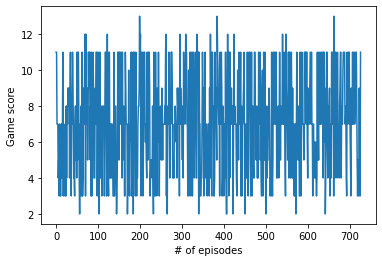

In [13]:
plt.plot(np.arange(len(env.dqnAgent.reward_history)), env.dqnAgent.reward_history)
plt.xlabel("# of episodes")
plt.ylabel("Game score")

**-----End of algorithm-----**

**Preprocessing Steps(Just for reference)**

['NOOP', 'FIRE', 'RIGHT', 'LEFT']


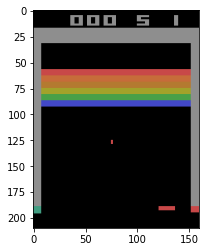

In [ ]:
env = gym.make("BreakoutDeterministic-v4")
env.reset()
print(env.unwrapped.get_action_meanings())
for i in range(5):
  env.step(np.random.choice(env.action_space.n))
  plt.imshow(env.render('rgb_array'))

['NOOP', 'FIRE', 'RIGHT', 'LEFT']
(210, 160, 3)
(210, 160, 3)


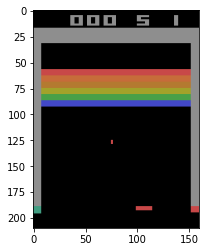

In [ ]:
env = gym.make("BreakoutDeterministic-v4")
print(env.unwrapped.get_action_meanings())
state = env.reset()
print(state.shape)
state,_,_,_ = env.step(1)
plt.imshow(state)
print(state.shape)

(160, 160, 3)


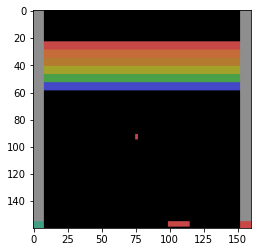

In [ ]:
state = state[34:-16,:,:]
plt.imshow(state)
print(state.shape)

(80, 80)


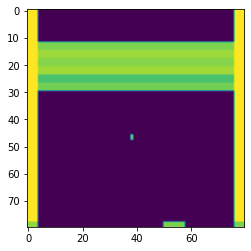

In [ ]:
state = np.mean(state[::2, ::2], axis=2).astype(np.uint8)
plt.imshow(state)
print(state.shape)

(80, 80)
(80, 80, 4)


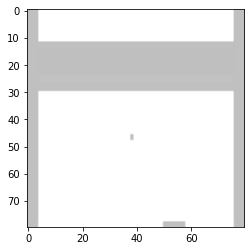

In [ ]:
import numpy as np
print(state.shape)
observation = np.stack((state, state, state, state), axis=2)
print(observation.shape)
plt.imshow(observation)

**Referenced Code for rendering video** Reference:https://star-ai.github.io/Rendering-OpenAi-Gym-in-Colaboratory/

In [ ]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

!pip install gym pyvirtualdisplay 
!apt-get install -y xvfb python-opengl ffmpeg


Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (47.3.1)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl xvfb
0 upgraded, 2 newly installed, 0 to remove and 69 not upgraded.
Need to get 1,280 kB of archives.
After this operation, 7,682 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.4 [784 kB]
Fetched 1,280 kB in 3s (500 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 144328 files and directo

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay


In [ ]:

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env